# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [1]:
%matplotlib inline
import lightkurve as lk
import gatspy
import matplotlib.pyplot as plt
import numpy as np
import emcee
import scipy.stats as st


Bad key "text.kerning_factor" on line 4 in
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#ls=gatspy.periodic.LombScargle().fit(x,y,dy)
#ls.optimizer.period_range = (T1-10,T1+20)
#T1_fitted = ls.best_period

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


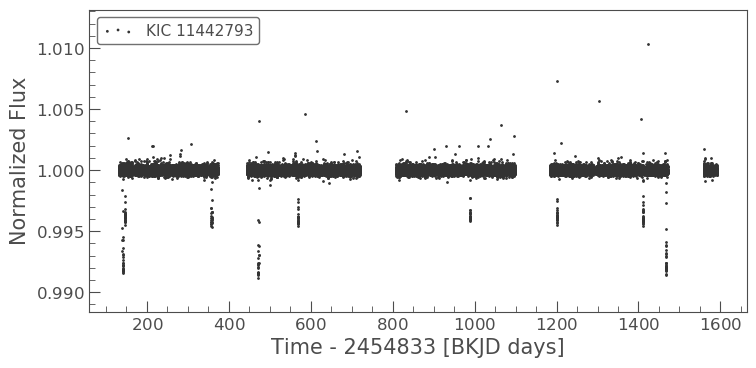

In [2]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter(); #clc=corrected light curve

y = clc.flux
dy = clc.flux_err
x = clc.time

In [71]:
def rectangular_pulse(x,w=1.0,a=1.0,duty=0.5,phase=0,i=100):
    """
    generates a rectangular wave with: Amplitude when hi, 0 when lo 

        x = the inputs to evaluate on (1-D numpy array)
        w = 1.0 the angular frequency (2*np.pi/period)
        a = 1.0 , amplitude, the value of hi, else = 0
        duty = 0.5 , duty cycle, the fractional amount of time the pulse i high, must be less than 1
        i = int(100) the number of fourier components to add, must be int
        phase = phase in degrees, phase of zero means square wave is half through a high at t=0
    """
    #if (0. <= duty <= 1.) == False:
    #    raise Exception('duty cycle must be less than or equal to one, greater than or equal to 0')
    if type(i) != int:
        raise Exception('number of fourier components i must be an integer')
    if i < 1:
        raise Exception('number of fourier components i must be greater than or equal to one')
    
    phase = phase*np.pi/180 #convert to radians
    
    x_phase = (phase/w) #phase, now in units of x

    Y=np.zeros((len(x)))#pre-allocate arrays
    prefactors_a=np.ones((i))

    prefactors_a[1::]=(2)/(np.arange(1,i,1)[np.newaxis]*np.pi)*np.sin((duty)*np.arange(1,i,1)*np.pi)
    prefactors_a[0] = duty
    
    Y += np.sum(np.cos((np.arange(0,i,1)[:,np.newaxis]*w*(x[np.newaxis,:]-x_phase)))*(prefactors_a[:,np.newaxis]),0)

    return(Y*a)

In [19]:
# lets find the periods, or estimates of them.

T1_list= [139,470,1465]
T2_list= [146,360,566,988,1198,1410]

#seems like sometimes f1's trigger occurs when we aren't observing. 
T1 = 470-139 #days
T2 = np.median([T2_list[1]-T2_list[0],T2_list[2]-T2_list[1],(T2_list[3]-T2_list[2])/2,T2_list[4]-T2_list[3],T2_list[5]-T2_list[4]])
print('guess T1: ', T1)
print('guess T2: ', T2)

x_1 = T1_list[1] + T1
print(x_1)
x_2 = T1_list[1]+2*T1
t0_2 = T2_list[1] - T2
t0_1 = T1_list[1] - T1

guess T1:  331
guess T2:  211.0
801


In [18]:
x_1 = T1_list[1] + T1
print(x_1)
x_2 = T1_list[1]+2*T1
t0_2 = T2_list[1] - T2
t0_1 = T1_list[1] - T1
#large amounts of gibbs phenemona will contribute to my loss
clc.scatter()
plt.vlines([x_1,x_2],0.990,1.010,color='r') #nice
plt.plot(x,1+rectangular_pulse(x,w=2*np.pi/T1,a=-0.0085,phase=155,duty=0.007),'g.',alpha=0.1)
plt.plot(x,1+rectangular_pulse(x,w=2*np.pi/T2,a=-0.0045,phase=252,duty=0.007),'b.',alpha=0.1)
plt.show()

NameError: name 'T1_list' is not defined

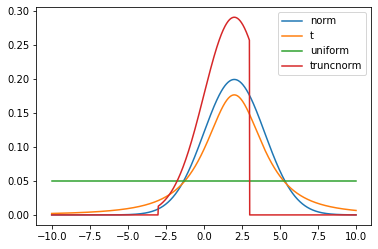

In [8]:
#lets remember how to use this module

x1=np.linspace(-10,10,1000)
gauss1 = st.norm(loc=2,scale=2)
y1=gauss1.pdf(x1)
plt.plot(x1,y1,label='norm')

x1=np.linspace(-10,10,1000)
t1 = st.t(df=2,loc=2,scale=2) #lower df allows more outliers
y1=t1.pdf(x1)
plt.plot(x1,y1,label='t')

u1=st.uniform(loc=-10,scale=20) #loc = start, loc+scale = end
y1 = u1.pdf(x1)
plt.plot(x1,y1,label='uniform')


#trunc norm has a silly definition of a and b we need to accomodate
my_std=2
my_mean=2
my_clipa=-3
my_clipb=3
a, b = (my_clipa - my_mean) / my_std, (my_clipb - my_mean) / my_std

gauss2 = st.truncnorm(a,b,loc=my_mean,scale=my_std)
y1=gauss2.pdf(x1)
plt.plot(x1,y1,label='truncnorm')

plt.legend()

In [61]:
#model is 1 + big square wave that is the main planet moving in front of star + sinuosoid for planet moving behind star to reflect
#light back at us, then second square wave that cuts the sinusoid off back to just 1 + noise

#square wave = A_m_1 * 4/np.pi * (np.sin(w_1*t) + 1/3 * np.sin(3*w_1*t) * 1/5 * np.sin(5*w_1*t) + 1/7 * np.sin(7*w_1*t))
#reflection wave = A_r_1 * np.sin(w_1*t)
#kill_wave = 

#If we isolate the signal we could probably find a radius measure by the transience.

#except now I dont want a square wave but a rectagular wave with a large duty cycle
#previous work:
T1_list= [139,470,1465]
T2_list= [146,360,566,988,1198,1410]

#seems like sometimes f1's trigger occurs when we aren't observing. 
T1 = 470-139 #days
T2 = np.median([T2_list[1]-T2_list[0],T2_list[2]-T2_list[1],(T2_list[3]-T2_list[2])/2,T2_list[4]-T2_list[3],T2_list[5]-T2_list[4]])
print('guess T1: ', T1)
print('guess T2: ', T2)
"""
Prior and Model

T1=T1 #around this number
A_1_block = #around -0.085
D_1_block = #0<0.02
A_1_kill = #less than 0, more than -0.002
D_1_kill = #0<0.1 is pretty uninformed
phase_1 =  #around 155
w_1 = 2*np.pi/T1

Model_1 = rectangular_pulse(x,w=w_1,amplitude=A_1_block,duty_cycle=D_1_block,phase=phase_1) + A_1_kill*sin(x*w_1-phase_1) + rectangular_pulse(x,amplitude=A_1_kill,duty_cycle=D_1_kill,phase=phase_1+np.pi)

T2=T2 #around this number
A_2_block = #around-0.045
D_2_block = #0<0.02
A_2_kill = #less than 0 more than -0.002
D_2_kill = #0<0.1 is pretty uninformed
phase_2 =  #around 252
w_2 = 2*np.pi/T2

Model_2 = rectangular_pulse(x,w=w_2,amplitude=A_2_block,duty_cycle=D_2_block,phase=phase_2) + A_2_kill*sin(x*w_2-phase_2) + rectangular_pulse(x,amplitude=A_2_kill,duty_cycle=D_2_kill,phase=phase_2+np.pi)

#now I know litterally nothing about this third planet Model
T3= #(anywhere between 1 and 1600 days)
A_3_block = #less than 0, more than -0.01
D_3_block = #anywhere between 0 and 1
A_3_kill = #less than 0, more than -0.01
D_3_kill = #anywhere between 0 and 1
phase_3 =  #anwhere between 0 and 360
w_3 = 2*np.pi/T3

Model_3 = rectangular_pulse(x,w=w_3,amplitude=A_3_block,duty_cycle=D_3_block,phase=phase_3) + A_3_kill*sin(x*w_3-phase_3) + rectangular_pulse(x,amplitude=A_3_kill,duty_cycle=D_3_kill,phase=phase_3+np.pi)

Model = 1 + Model_1 + Model_1 + Model_3
"""
prob_A_1_block = st.norm(loc=-0.085,scale=0.03)
prob_D_1_block = st.uniform(loc=0,scale=0.2)
prob_A_1_kill = st.uniform(loc=-0.2,scale=0.2)
prob_D_1_kill = st.uniform(loc=0,scale=0.1)
prob_phase_1 = st.norm(loc=155,scale=15)
prob_w_1 = st.norm(loc=2*np.pi/T1, scale=25)

prob_A_2_block = st.norm(loc=-0.085,scale=0.03)
prob_D_2_block = st.uniform(loc=0,scale=0.2)
prob_A_2_kill = st.uniform(loc=-0.2,scale=0.2)
prob_D_2_kill = st.uniform(loc=0,scale=0.1)
prob_phase_2 = st.norm(loc=252,scale=15)
prob_w_2 = st.norm(loc=2*np.pi/T2, scale=25)

prob_A_3_block = st.uniform(loc=-0.01,scale=0.01)
prob_D_3_block = st.uniform(loc=0,scale=0.5)
prob_A_3_kill = st.uniform(loc=-0.01,scale=0.01)
prob_D_3_kill = st.uniform(loc=0,scale=0.5)
prob_phase_3 = st.uniform(loc=0,scale=360)
prob_w_3 = st.uniform(loc=0,scale=2*np.pi)
"""
#test code

pos = np.array([-0.085,0.01,-0.001,0.05,155,2*np.pi/T1,-0.045,0.01,-0.001,0.05,252,2*np.pi/T2,-0.005,0.01,-0.005,0.01,0,2*np.pi/365])
A_1_block, D_1_block, A_1_kill, D_1_kill, phase_1, w_1, A_2_block, D_2_block, A_2_kill, D_2_kill, phase_2, w_2,A_3_block, D_3_block, A_3_kill, D_3_kill, phase_3, w_3 = pos

print(not((0<=D_1_block<=0.2) and (0<=D_1_kill<=0.1) and (-0.2<=A_1_kill<=0)))
    #return -1*np.inf

print(not((0<=D_2_block<=0.2) and (0<=D_2_kill<=0.1) and (-0.2<=A_2_kill<=0)))
    #return -1*np.inf

print(not((-0.01<=A_3_block<=0) and (0<=D_3_block<=0.5) and (0<=D_3_kill<=0.5) and (-0.01<=A_3_kill<=0) and (0<=phase_3<=360) and (0<=w_3<=2*np.pi)))
    #return -1*np.inf
print('start check')
print(-0.01<A_3_block<0)
print(0<D_3_block<0.5)
print(0<D_3_kill<0.5)
print(-0.01<A_3_kill<0)
print(0<phase_3<360)
print(0<w_3<2*np.pi/1600)

pos = np.array([-0.085,0.01,-0.001,0.05,155,2*np.pi/T1,-0.045,0.01,-0.001,0.05,252,2*np.pi/T2,-0.005,0.01,-0.005,0.01,0,2*np.pi/365])
log_prior(pos)
"""

guess T1:  331
guess T2:  211.0
False
False
False
start check
True
True
True
True
False
False


-inf

In [10]:
def log_likelihood(theta, x, y, dy):
    A_1_block, D_1_block, A_1_kill, D_1_kill, phase_1, w_1, A_2_block, D_2_block, A_2_kill, D_2_kill, phase_2, w_2,A_3_block, D_3_block, A_3_kill, D_3_kill, phase_3, w_3 = theta
    
    Model_1 = rectangular_pulse(x,w=w_1,a=A_1_block,duty=D_1_block,phase=phase_1) + A_1_kill*np.cos(x*w_1-(phase_1*np.pi/180)-np.pi) + rectangular_pulse(x,a=A_1_kill,duty=D_1_kill,phase=phase_1+180)
    Model_2 = rectangular_pulse(x,w=w_2,a=A_2_block,duty=D_2_block,phase=phase_2) + A_2_kill*np.cos(x*w_2-(phase_2*np.pi/180)-np.pi) + rectangular_pulse(x,a=A_2_kill,duty=D_2_kill,phase=phase_2+180)
    Model_3 = rectangular_pulse(x,w=w_3,a=A_3_block,duty=D_3_block,phase=phase_3) + A_3_kill*np.cos(x*w_3-(phase_3*np.pi/180)-np.pi) + rectangular_pulse(x,a=A_3_kill,duty=D_3_kill,phase=phase_3+180)
    
    model = Model_1 + Model_2 + Model_3 + 1
    
    return -0.5 * np.sum((y - model) ** 2 / dy**2) #not resilient to outliers. May be a problem.

In [65]:
def log_prior(theta):
    A_1_block, D_1_block, A_1_kill, D_1_kill, phase_1, w_1, A_2_block, D_2_block, A_2_kill, D_2_kill, phase_2, w_2, A_3_block, D_3_block, A_3_kill, D_3_kill, phase_3, w_3 = theta
    
    if not((0<=D_1_block<=0.2) and (0<=D_1_kill<=0.1) and (-0.2<=A_1_kill<=0)):
        return -1*np.inf
    
    if not((0<=D_2_block<=0.2) and (0<=D_2_kill<=0.1) and (-0.2<=A_2_kill<=0)):
        return -1*np.inf
    
    if not((-0.01<=A_3_block<=0) and (0<=D_3_block<=0.5) and (0<=D_3_kill<=0.5) and (-0.01<=A_3_kill<=0) and (0<=phase_3<=360) and (0<=w_3<=2*np.pi)):
        return -1*np.inf
    
    prob=0
    prob+=np.log(prob_A_1_block.pdf(A_1_block))
    prob+=np.log(prob_D_1_block.pdf(D_1_block))
    prob+=np.log(prob_A_1_kill.pdf(A_1_kill))
    prob+=np.log(prob_D_1_kill.pdf(D_1_kill))
    prob+=np.log(prob_phase_1.pdf(phase_1))
    prob+=np.log(prob_w_1.pdf(w_1))
    
    prob+=np.log(prob_A_2_block.pdf(A_2_block))
    prob+=np.log(prob_D_2_block.pdf(D_2_block))
    prob+=np.log(prob_A_2_kill.pdf(A_2_kill))
    prob+=np.log(prob_D_2_kill.pdf(D_2_kill))
    prob+=np.log(prob_phase_2.pdf(phase_2))
    prob+=np.log(prob_w_2.pdf(w_2))
    
    prob+=np.log(prob_A_3_block.pdf(A_3_block))
    prob+=np.log(prob_D_3_block.pdf(D_3_block))
    prob+=np.log(prob_A_3_kill.pdf(A_3_kill))
    prob+=np.log(prob_D_3_kill.pdf(D_3_kill))
    prob+=np.log(prob_phase_3.pdf(phase_3))
    prob+=np.log(prob_w_3.pdf(w_3))
    
    return -1 * (prob)

#pos = np.array([-0.085,0.01,-0.001,0.05,155,2*np.pi/T1,-0.045,0.01,-0.001,0.05,252,2*np.pi/T2,-0.005,0.01,-0.005,0.01,0,2*np.pi/365])
#log_prior(pos)

-2.672319125543283

In [86]:
def log_probability(theta, x, y, dy):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, dy)

In [90]:
y = clc.flux
dy = clc.flux_err
x = clc.time

ndim = 18#how many free parameters
nwalkers= ndim*2#how many chains

pos = np.array([-0.085,0.01,-0.001,0.05,155,2*np.pi/T1,-0.045,0.01,-0.001,0.05,252,2*np.pi/T2,-0.005,0.01,-0.005,0.01,0,2*np.pi/365]) \
    + np.random.normal(loc=0,scale=0.01,size=(nwalkers,ndim))


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, dy))

sampler.run_mcmc(pos, 1000)

C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


emcee: Exception while calling your likelihood function:
  params: [-8.29959819e-02  5.12551851e-04 -1.33430916e-03  5.12783183e-02
  1.54998603e+02  1.91159135e-02 -4.42463897e-02  1.52778430e-02
 -7.13521020e-04  5.10410383e-02  2.52002106e+02  3.29495489e-02
 -3.74321373e-03  1.47456985e-02 -2.14874515e-03  8.88513380e-03
  4.02042637e-03  1.60257674e-02]
  args: (array([ 131.51243946,  131.53287376,  131.55330797, ..., 1590.96091289,
       1590.98134703, 1591.00178137]), array([0.99988999, 1.00014328, 0.99998635, ..., 1.00004946, 1.00009939,
       1.00003396]), array([0.00017644, 0.00017655, 0.00017656, ..., 0.00017726, 0.00017711,
       0.00017716]))
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\emcee\ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-86-cfc75fbd969e>", line 5, in log_probability
    return lp + log_likelihood(theta, x, y, dy)
  File "<ipython-input-10-9af871b4be42>", line 4, in log_likelihood
    Model_1 = rectangular_pulse(x,w=w_1,a=A_1_block,duty=D_1_block,phase=phase_1) + A_1_kill*np.cos(x*w_1-(phase_1*np.pi/180)-np.pi) + rectangular_pulse(x,a=A_1_kill,duty=D_1_kill,phase=phase_1+180)
  File "<ipython-input-71-b370b00b9c81>", line 29, in rectangular_pulse
    Y += np.sum(np.cos((np.arange(0,i,1)[:,np.newaxis]*w*(x[np.newaxis,:]-x_phase)))*(prefactors_a[:,np.newaxis]),0)
KeyboardInterrupt


KeyboardInterrupt: 

In [207]:
#Had to run this in the campus cluster, here is the chain:
MCMC_chains=np.load('markov_chain.npy')
np.shape(MCMC_chains)

(36, 5000, 18)

In [213]:
labels=['A_1_block','D_1_block','A_1_kill','D_1_kill','phase_1','w_1','A_2_block','D_2_block','A_2_kill','D_2_kill','phase_2','w_2','A_3_block','D_3_block','A_3_kill','D_3_kill','phase_3','w_3']

In [239]:
## fig, axes = plt.subplots(18, figsize=(20, 27), sharex=True)
samples = MCMC_chains

for i in range(18):
    ax = axes[i]
    ax.plot(np.arange(0,5000,1),samples[20, :, i], "k", alpha=0.6)
    ax.set_xlim(0, 5000)
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

#throw away [0,2,3,5,6,7,9,10,11,12,13,14,15,16,17,18 ]#failed chains]
#1 kills duty 1,8 kills duty 1,

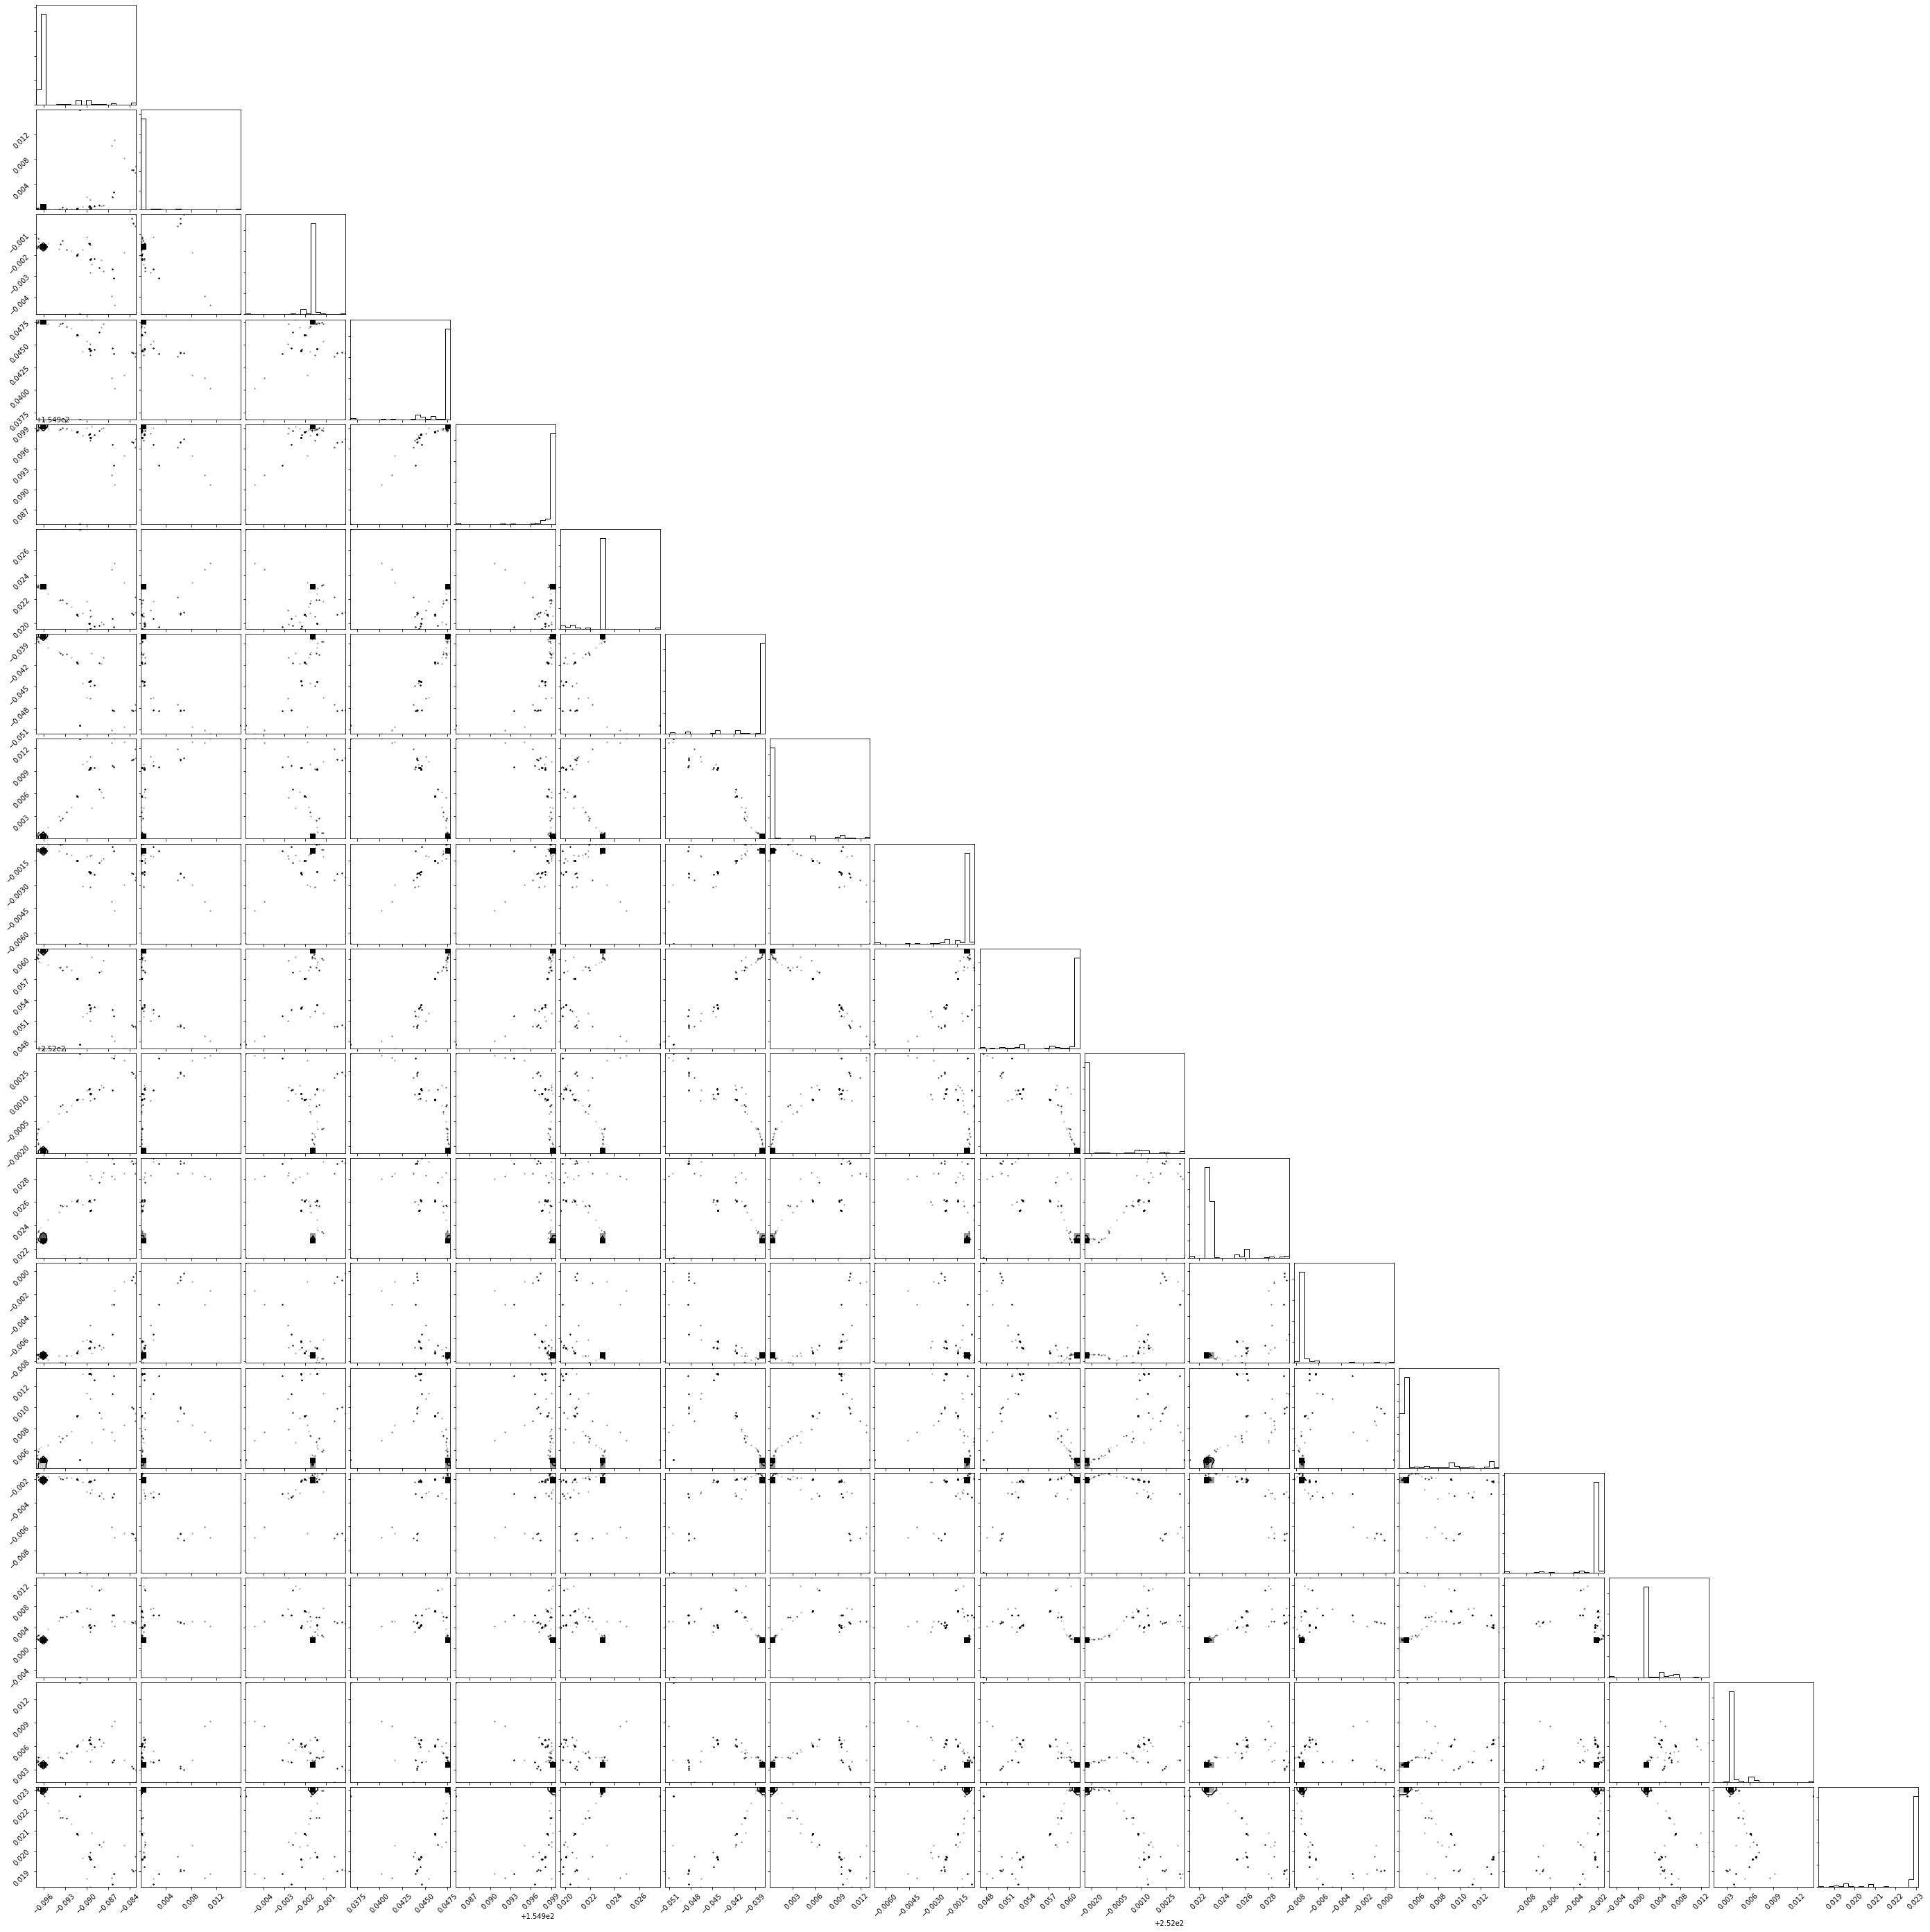

In [240]:
import corner

figure = corner.corner(MCMC_chains[1,:,:],quantiles=[0.16, 0.5, 0.84])

<h1>Okay, so my MCMC is not working well: Takes way long to sample, its 9:14 on Wednesday, time to look at other things</h1>

<h1> And Probably the square wave is not a good choice for a model since there are points that are on the climb and decline.</h1>

<h1> If I wanted to pursue it serriously, I would need an additional filter that adds a longer slope to the square, and maybe try to filter out the Gibbs excess<h1>

<h1>Gatspy + lightkurve<h1>

<h3>From Google:The “box least squares (BLS) periodogram” 1 is a statistical tool used for detecting transiting exoplanets and eclipsing binaries in time series photometric data.</h3>

In [3]:
periodogram = clc.to_periodogram(method='boxleastsquares',period=np.arange(10, 400, 0.05))
periodogram.plot()

()

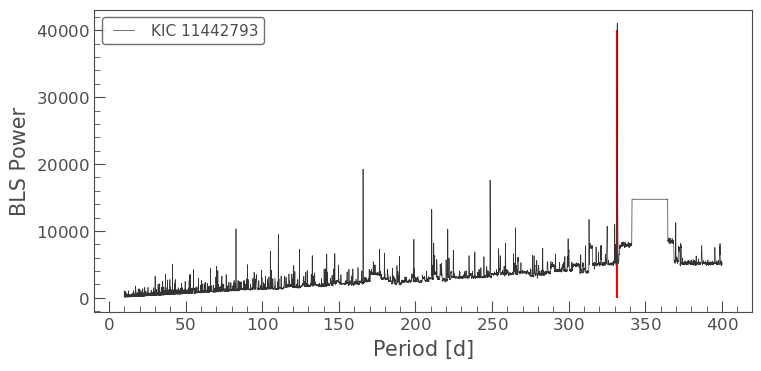

In [7]:
period_1 = periodogram.period_at_max_power
periodogram.plot()
plt.vlines(period_1.value,0,40000,'r')
#I know from square that we also want to find the multiples of frequency that build a square wave, or resonances


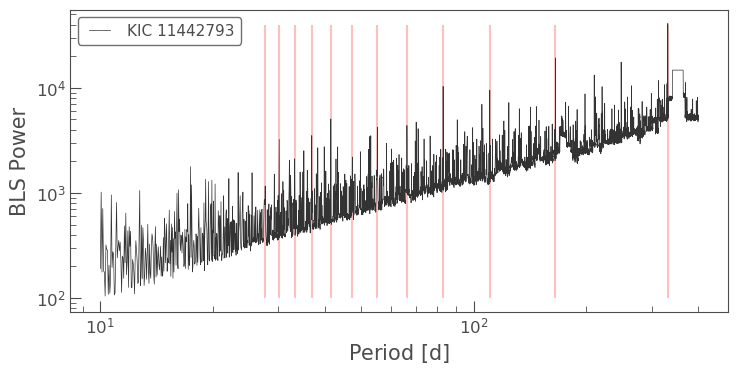

In [14]:
period_1 = periodogram.period_at_max_power
periodogram.plot()
a=np.arange(1,13)#dont divide by 0; tried doing 20 resonances, but at 14 seems to be off. so keep up to 13?
period_1_resonances = period_1.value/a #proportional to i*np.pi*2/T
plt.vlines(period_1_resonances,100,40000,'r',alpha=0.25)
plt.xscale('log')
plt.yscale('log')

In [23]:
print(periodogram.transit_time_at_max_power)
print(t0_1)
print('neat')

140.4874394588347
139
neat


(-0.05, 0.05)

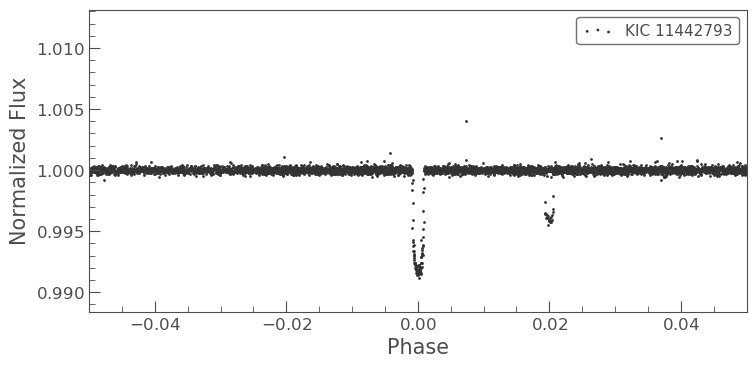

In [25]:
clc.fold(period=period_1,t0=periodogram.transit_time_at_max_power).scatter()
plt.xlim(-0.05,0.05)

In [68]:
print(period_1)

331.60000000000457 d


<h2>I can create a mask of size 10 days around each point that is transit time 1 + T1 for n in 1600 since periodogram already works well for uneven sampling<h2>

In [52]:
start_1 = periodogram.transit_time_at_max_power
centers1 = start_1 + T1*np.arange(0,10,1)
#cut centers at times greater than our data range
maskcenters1=centers1<np.max(x)
centers1=centers1[maskcenters1]

filter_size=5 #days
mask1 = np.ones(len(x),dtype=bool)
for value in centers1:
    filtercurrent=(np.logical_or(x>value+filter_size,x<value-filter_size))
    mask1=np.logical_and(mask1,filtercurrent)

<h1>Confirm filter size was correct<h1>

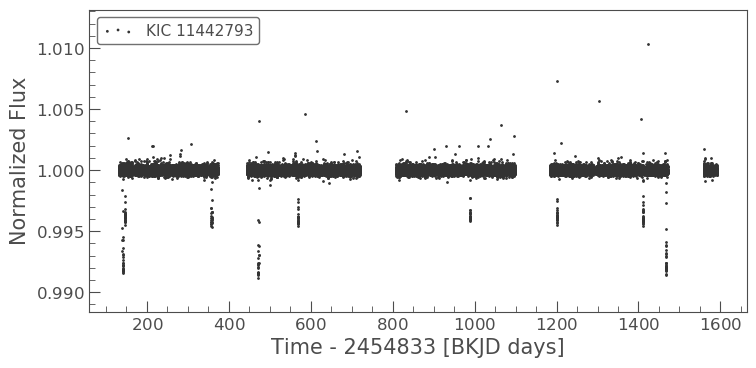

In [38]:
clc.scatter()

lost first one but its fiinnnne


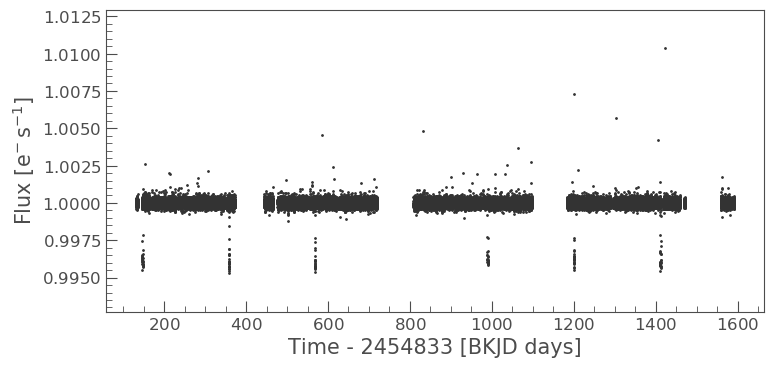

In [53]:
clc2 = lk.lightcurve.KeplerLightCurve(clc.time[mask1],clc.flux[mask1],clc.flux_err[mask1])
clc2.scatter()

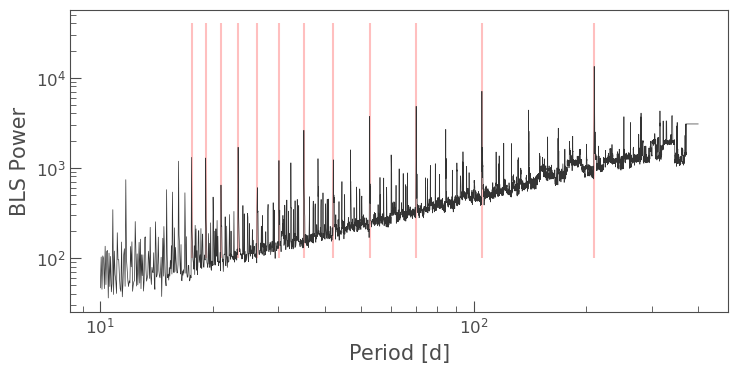

210.60000000000286 d


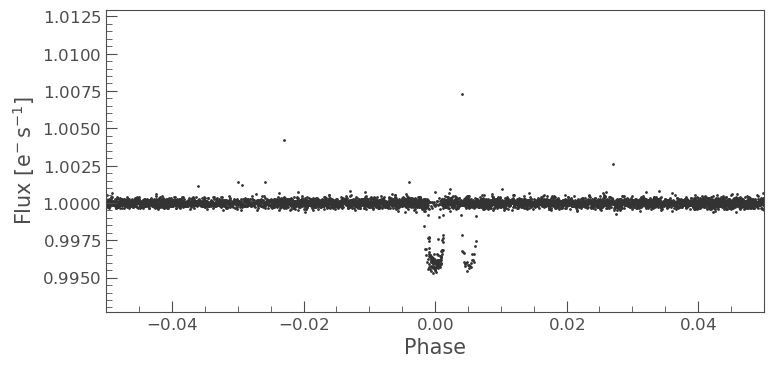

In [67]:
periodogram2 = clc2.to_periodogram(method='boxleastsquares',period=np.arange(10, 400, 0.05))
period_2 = periodogram2.period_at_max_power
periodogram2.plot()
a=np.arange(1,13)#dont divide by 0; tried doing 20 resonances, but at 14 seems to be off. so keep up to 13?
period_2_resonances = period_2.value/a #proportional to i*np.pi*2/T
plt.vlines(period_2_resonances,100,40000,'r',alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.show()

clc2.fold(period=period_2,t0=periodogram2.transit_time_at_max_power).scatter()
plt.xlim(-0.05,0.05)

print(period_2)

<h1>Planet three</h1>

In [62]:
start_2 = periodogram2.transit_time_at_max_power
centers2 = start_2 + period_2.value*np.arange(0,10,1)
#cut centers at times greater than our data range
maskcenters2=centers2<np.max(clc2.time)
centers2=centers2[maskcenters2]
print(centers2)

filter_size=5 #days
mask2 = np.ones(len(clc2.time),dtype=bool)
for value in centers2:
    filtercurrent=(np.logical_or(clc2.time>value+filter_size,clc2.time<value-filter_size))
    mask2=np.logical_and(mask2,filtercurrent)

[ 147.06243946  357.66243946  568.26243946  778.86243946  989.46243946
 1200.06243946 1410.66243946]


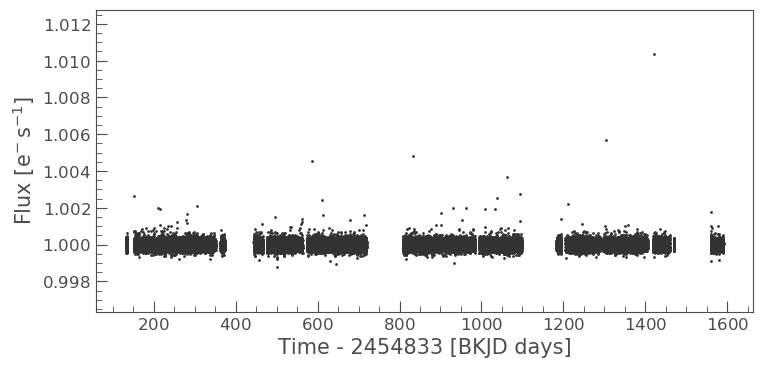

In [63]:
clc3 = lk.lightcurve.KeplerLightCurve(clc2.time[mask2],clc2.flux[mask2],clc2.flux_err[mask2])
clc3.scatter()

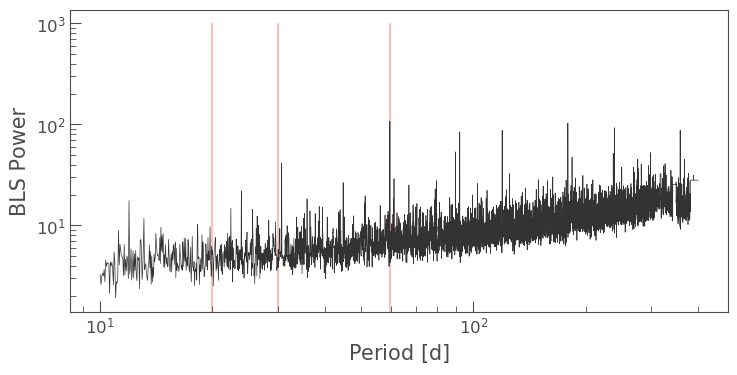

59.75000000000071 d


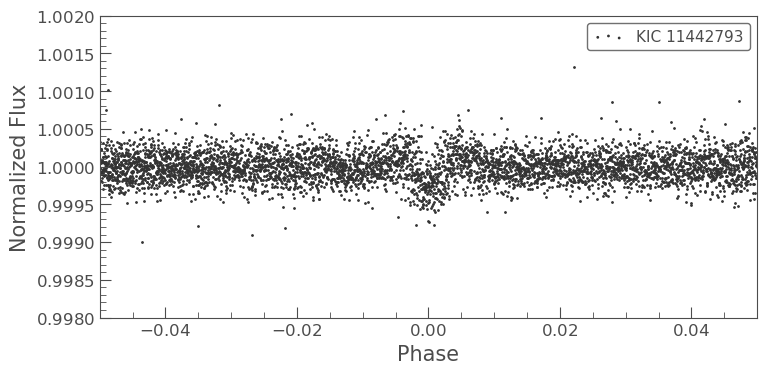

In [71]:
periodogram3 = clc3.to_periodogram(method='boxleastsquares',period=np.arange(10, 400, 0.05))
period_3 = periodogram3.period_at_max_power
periodogram3.plot()
a=np.arange(1,4)#dont divide by 0; tried doing 20 resonances, but at 14 seems to be off. so keep up to 13?
period_3_resonances = period_3.value/a #proportional to i*np.pi*2/T
plt.vlines(period_3_resonances,0,1000,'r',alpha=0.25)
plt.xscale('log')
plt.yscale('log')
plt.show()

clc.fold(period=period_3,t0=periodogram3.transit_time_at_max_power).scatter()
plt.xlim(-0.05,0.05)
plt.ylim(0.998,1.002)
print(period_3)

<h1>In summary, three exoplanets with periods:(60,210,331) days.</h1>

<h1>This corresponds to kepler-90 planets d,h,g<h1>

<h1>Gaussian Process...?</h1>

In [242]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF as SquaredExponential

In [243]:
h = 5.0#shortening length scale makes the GP 'tighter', I think our data is tight, on transit time of about 5 days

kernel = SquaredExponential(length_scale=h, length_scale_bounds=(0.01, 100.0))
gp0 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [244]:
xgrid = np.atleast_2d(np.linspace(0, 1600, 1600)).T

# Draw three sample y(x) functions:
draws = gp0.sample_y(xgrid, n_samples=3)

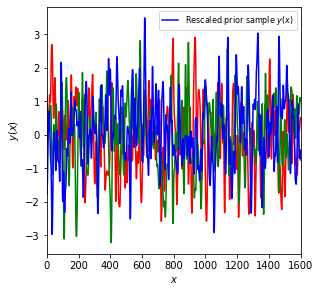

In [246]:
# Start a 4-panel figure:
fig = plt.figure(figsize=(10,10))

# Plot our three prior draws:
ax = fig.add_subplot(221)
ax.plot(xgrid, draws[:,0], '-r')
ax.plot(xgrid, draws[:,1], '-g')
ax.plot(xgrid, draws[:,2], '-b', label='Rescaled prior sample $y(x)$')
ax.set_xlim(0, 1600)
#ax.set_ylim(0.99, 1.01)
ax.set_xlabel('$x$')
ax.set_ylabel('$y(x)$')
ax.legend(fontsize=8);

In [247]:
class Rescale():
    def __init__(self, y, err):
        self.original_data = y
        self.original_err = err
        self.mean = np.mean(y)
        self.std = np.std(y)
        self.transform()
        return
    def transform(self):
        self.y = (self.original_data - self.mean) / self.std
        self.err = self.original_err / self.std
        return()
    def invert(self, scaled_y, scaled_err):
        return (scaled_y * self.std + self.mean, scaled_err * self.std) 

In [250]:
y = clc.flux
dy = clc.flux_err
x = clc.time

rescaled = Rescale(y, dy)
print('Mean, variance of original data: ',np.round(np.mean(y)), np.round(np.var(y)))
print('Mean, variance of rescaled data: ',np.round(np.mean(rescaled.y)), np.round(np.var(rescaled.y)))

y2, dy2 = rescaled.invert(rescaled.y, rescaled.err)
print('Mean, variance of inverted, rescaled data: ',np.round(np.mean(y2)), np.round(np.var(y2)))
print('Maximum differences in y, sigmay, after round trip: ',np.max(np.abs(y2 - y)), np.max(np.abs(sigmay2 - dy)))

Mean, variance of original data:  1.0 0.0
Mean, variance of rescaled data:  0.0 1.0
Mean, variance of inverted, rescaled data:  1.0 0.0
Maximum differences in y, sigmay, after round trip:  0.0 0.0


In [251]:
# Choose two of our (rescaled) datapoints:
x1 = np.array([x[10], x[12]])
rescaled_y1 = np.array([rescaled.y[10], rescaled.y[12]])
rescaled_sigmay1 = np.array([rescaled.err[10], rescaled.err[12]])

# Instantiate a GP model, with initial length_scale h=10:
kernel = SquaredExponential(length_scale=h, length_scale_bounds=(0.01, 1000.0))
gp1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit it to our two noiseless datapoints:
gp1.fit(x1[:, None], rescaled_y1)

# We have fit for the length scale parameter: print the result here:
params = gp1.kernel_.get_params()
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',h)

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid1, rescaled_ygrid1_err = gp1.predict(xgrid, return_std=True)

# And undo scaling, of both y(x) on our grid, and our two constraining data points:
ygrid1, ygrid1_err = rescaled.invert(rescaled_ygrid1, rescaled_ygrid1_err)
y1, sigmay1 = rescaled.invert(rescaled_y1, rescaled_sigmay1)

Best-fit kernel length scale = 0.08306676499324248 cf. input 5.0


C:\Users\qwsaz\Anaconda3\envs\DAMLA\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


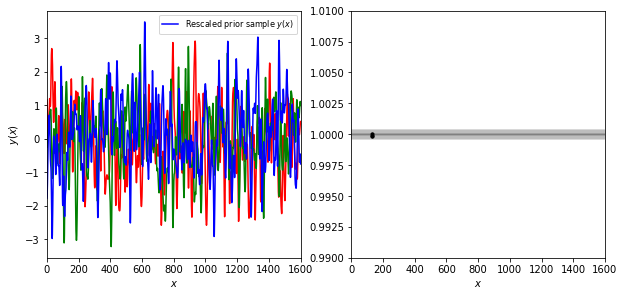

In [253]:
ax = fig.add_subplot(222)
ax.plot(xgrid, ygrid1, '-', color='gray', label='Posterior mean $y(x)$')
ax.fill(np.concatenate([xgrid, xgrid[::-1]]),
        np.concatenate([(ygrid1 - ygrid1_err), (ygrid1 + ygrid1_err)[::-1]]),
        alpha=0.3, fc='gray', ec='None', label='68% confidence interval')
ax.plot(x1, y1, '.k', ms=6, label='Noiseless constraints')
ax.set_xlim(0, 1600)
ax.set_ylim(0.99, 1.01)
ax.set_xlabel('$x$')
fig

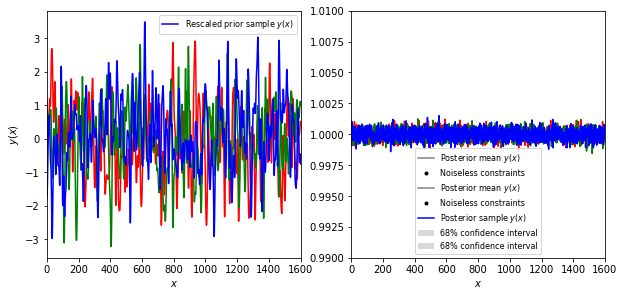

In [254]:
draws = gp1.sample_y(xgrid, n_samples=3)
for k in range(3):
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

ax.plot(xgrid, draws[:,0], '-r')
ax.plot(xgrid, draws[:,1], '-g')
ax.plot(xgrid, draws[:,2], '-b', label='Posterior sample $y(x)$')
ax.legend(fontsize=8)
fig

In [255]:
# Use every tenth datapoint:
x3 = x[0::10]
rescaled_y3 = rescaled.y[0::10]
rescaled_sigmay3 = rescaled.err[0::10]

# Instantiate a GP model, including observational errors:
kernel = SquaredExponential(length_scale=0.83, length_scale_bounds=(0.01, 100.0))
# Could comment this out, and then import and use an 
# alternative kernel here. 

gp3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, 
                               alpha=(rescaled_sigmay3 / rescaled_y3) ** 2,
                               random_state=0)

# Fit it to our noisy datapoints:
gp3.fit(x3[:, None], rescaled_y3)

# Now predict y(x) everywhere on our xgrid: 
rescaled_ygrid3, rescaled_ygrid3_err = gp3.predict(xgrid, return_std=True)

# And undo scaling:
ygrid3, ygrid3_err = rescaled.invert(rescaled_ygrid3, rescaled_ygrid3_err)
y3, sigmay3 = rescaled.invert(rescaled_y3, rescaled_sigmay3)

# We have fitted the length scale parameter - print the result here:
params = gp3.kernel_.get_params()
print('Kernel: {}'.format(gp3.kernel_))
print('Best-fit kernel length scale =', params['length_scale'],'cf. input',0.83)
print('Marginal log-Likelihood: {:.3f}'.format(gp3.log_marginal_likelihood(gp3.kernel_.theta)))

# Draw three posterior sample y(x):
draws = gp3.sample_y(xgrid, n_samples=3)
for k in range(3):
    draws[:,k], dummy = rescaled.invert(draws[:,k], np.zeros(len(xgrid)))

Kernel: RBF(length_scale=0.01)
Best-fit kernel length scale = 0.010000000000000004 cf. input 10.0
Marginal log-Likelihood: -11857.595


In [260]:
def gp_plot(ax, xx, yy, ee, datax, datay, datae, samples, legend=True):
    ax.cla()
    ax.plot(xx, yy, '-', color='gray', label='Posterior mean $y(x)$')
    ax.fill(np.concatenate([xx, xx[::-1]]),
            np.concatenate([(yy - ee), (yy + ee)[::-1]]),
            alpha=0.3, fc='gray', ec='None', label='68% confidence interval')
    ax.errorbar(datax, datay, datae, fmt='.k', ms=6, label='Noisy constraints')
    ax.set_xlim(0, 1600)
    ax.set_ylim(0.990, 1.01)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y(x)$')
    ax.plot(xgrid, samples[:,0], '-r')
    ax.plot(xgrid, samples[:,1], '-g')
    ax.plot(xgrid, samples[:,2], '-b', label='Posterior sample $y(x)$')
    if legend: ax.legend(fontsize=8)
    return

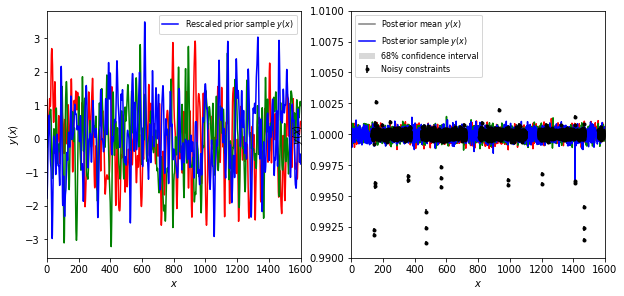

In [261]:
gp_plot(ax, xgrid, ygrid3, ygrid3_err, x3, y3, sigmay3, draws, legend=True)
fig

<h1>????????????<h1>